In [107]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import random
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
import statistics
from sklearn import preprocessing
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os.path

In [2]:
ticker = "FAS"

In [3]:
def getDB(ticker):
    tick = ticker
    # Load data
    data = yf.Ticker(tick)
    df = data.history(period="5y", interval="1d")
#     df = data.history(start="2018-12-01", end="2020-03-01")
#     start="2017-01-01", end="2017-04-30"
    
    # add data points
    df['close_per1'] = df.ta.percent_return(1)*100
    df['sma10'] = df.ta.sma(length=10)
    df['williams'] = df.ta.willr()


    df = df[[
            'open','close','sma10','williams','close_per1'
            ]]

    df = df.dropna()
    
    return df

In [4]:
data = getDB(ticker)
print(data['close_per1'].std())
print(data.head(15))
print(data.tail(15))

4.272248603590672
                 open      close      sma10   williams  close_per1
date                                                              
2017-01-20  39.440818  39.537014  40.232526 -70.000233    1.256465
2017-01-23  39.383103  39.344627  40.028588 -75.882355   -0.486599
2017-01-24  39.613984  40.354702  40.004539 -44.999845    2.567249
2017-01-25  41.345528  41.653358  40.106508  -5.294093    3.218104
2017-01-26  41.768794  41.778416  40.187314  -7.967055    0.300233
2017-01-27  41.730318  41.124275  40.254652 -26.648366   -1.565738
2017-01-30  40.450887  40.412407  40.213286 -46.978300   -1.731017
2017-01-31  39.941050  39.921810  40.295053 -60.989038   -1.213976
2017-02-01  40.575947  39.671696  40.284472 -68.131946   -0.626511
2017-02-02  39.344624  39.681313  40.347962 -67.857303    0.024241
2017-02-03  41.056932  41.634113  40.557672 -12.088123    4.921210
2017-02-06  41.076173  41.249329  40.748142 -23.077021   -0.924205
2017-02-07  41.643742  41.047318  40.817403 

In [5]:
def set_data(ticker):
    df = getDB(ticker)

    df['CP_ol'] = 0
    df['CO_il'] = 0
    df['SMA10_il'] = 0
    df['W_il'] = 0
    
    value = df['close_per1'].std()
    
    # setting the outputs in the df
    for i in range(len(df)):
        if df.iloc[i]['close_per1'] > value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 2
        elif df.iloc[i]['close_per1'] < -value:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 1
        else:
            df.iloc[i, df.columns.get_loc('CP_ol')] = 0
    
    # setting the inputs in the df
    for i in range(len(df)-1):
        try:
            if df.iloc[i]['close'] < df.iloc[i+1]['open']:
                df.iloc[i+1, df.columns.get_loc('CO_il')] = 1
            else:
                df.iloc[i+1, df.columns.get_loc('CO_il')] = 0
        except:
            df.iloc[i+1, df.columns.get_loc('CO_il')] = np.nan
            
    
    # setting the inputs in the df
    for i in range(len(df)):
        try:
            if df.iloc[i]['close'] > df.iloc[i]['sma10']:
                df.iloc[i, df.columns.get_loc('SMA10_il')] = 1
            else:
                df.iloc[i, df.columns.get_loc('SMA10_il')] = 0
        except:
            df.iloc[i, df.columns.get_loc('SMA10_il')] = np.nan
            
    
    # setting the inputs in the df
    for i in range(len(df)):
        if df.iloc[i]['williams'] > -30: # overbought
            df.iloc[i, df.columns.get_loc('W_il')] = -1
        elif df.iloc[i]['williams'] < -70: # oversold
            df.iloc[i, df.columns.get_loc('W_il')] = 1
        else:
            df.iloc[i, df.columns.get_loc('W_il')] = 0 # neutral
    
    
    # deleting data that is not normalized
    del df['open']
    del df['close']
    del df['sma10']
    del df['williams']
#     del df['close_per1']
    
    # reformating
    df = df[[
            'W_il','SMA10_il','CO_il','CP_ol','close_per1'
            ]]
    
    return df

In [6]:
df = set_data(ticker)
print(data.head())
print(data.tail())

                 open      close      sma10   williams  close_per1
date                                                              
2017-01-20  39.440818  39.537014  40.232526 -70.000233    1.256465
2017-01-23  39.383103  39.344627  40.028588 -75.882355   -0.486599
2017-01-24  39.613984  40.354702  40.004539 -44.999845    2.567249
2017-01-25  41.345528  41.653358  40.106508  -5.294093    3.218104
2017-01-26  41.768794  41.778416  40.187314  -7.967055    0.300233
                  open       close       sma10   williams  close_per1
date                                                                 
2021-12-23  128.460007  128.789993  126.142220 -28.456477    1.898880
2021-12-27  129.820007  132.520004  126.454931 -12.336443    2.896196
2021-12-28  132.479996  132.509995  127.225233 -13.113711   -0.007553
2021-12-29  133.600006  132.289993  127.731278 -14.056528   -0.166026
2021-12-30  133.139999  132.619995  128.162655 -12.642303    0.249453


In [7]:
def process_train(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[0:-SHIFT]
        
        del df['close_per1']
        
        df.head()

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")



In [8]:
def process_test(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]
        
        del df['close_per1']
        df.head()

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-1]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!
        
        
        random.shuffle(sequential_data)  # shuffle for good measure.
        
        buy = []; notbuy = []; maybe = []
        
        for seq, target in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target])
            elif target == 1:
                notbuy.append([seq, target]) 
            elif target == 2:
                buy.append([seq, target])  
        
        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)
        
        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?
        
        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]
        
        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
    
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []
    for seq, target in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X).astype("float64"), np.array(y).astype("uint8")

In [89]:
SEQ_LEN = 2  # how long of a preceeding sequence to collect for RNN
# FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
SHIFT = 150  # how far to shift the data so it can be back testest
BATCH_SIZE = 64 # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
EPOCHS = 750 # how many passes through our data


tickers_train = [ticker]
tickers_test = [ticker]

train_x, train_y = process_train(tickers_train, SEQ_LEN,SHIFT)
validation_x, validation_y = process_test(tickers_test, SEQ_LEN, SHIFT)

In [90]:
print(train_x[0])
print('training data length: %d' % (len(train_x)))
print('validation data length: %d' % (len(validation_x)))

[[-1.  1.  1.]
 [-1.  1.  1.]]
training data length: 279
validation data length: 39


In [91]:
## Building the RNN ##
print()
print("length of train data: ", len(train_x))
print("length of validation data: ", len(validation_x))
print()

model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1:]), activation='tanh', return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(64, activation='tanh'))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(64, activation='tanh'))
# model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=1e-6)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y)
)

print()
print()

# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()


length of train data:  279
length of validation data:  39

Epoch 1/750
5/5 [==============================] - 3s 154ms/step - loss: 1.2055 - accuracy: 0.4229 - val_loss: 1.0976 - val_accuracy: 0.3846
Epoch 2/750
5/5 [==============================] - 0s 9ms/step - loss: 1.1898 - accuracy: 0.4409 - val_loss: 1.0975 - val_accuracy: 0.3590
Epoch 3/750
5/5 [==============================] - 0s 13ms/step - loss: 1.1848 - accuracy: 0.4337 - val_loss: 1.0974 - val_accuracy: 0.3590
Epoch 4/750
5/5 [==============================] - 0s 11ms/step - loss: 1.1723 - accuracy: 0.4229 - val_loss: 1.0974 - val_accuracy: 0.3077
Epoch 5/750
5/5 [==============================] - 0s 9ms/step - loss: 1.1548 - accuracy: 0.4301 - val_loss: 1.0973 - val_accuracy: 0.3333
Epoch 6/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1433 - accuracy: 0.4444 - val_loss: 1.0972 - val_accuracy: 0.3333
Epoch 7/750
5/5 [==============================] - 0s 10ms/step - loss: 1.1266 - accuracy: 0.4409 - v

5/5 [==============================] - 0s 8ms/step - loss: 0.9181 - accuracy: 0.5986 - val_loss: 1.0807 - val_accuracy: 0.3333
Epoch 60/750
5/5 [==============================] - 0s 8ms/step - loss: 0.9281 - accuracy: 0.5771 - val_loss: 1.0798 - val_accuracy: 0.3590
Epoch 61/750
5/5 [==============================] - 0s 8ms/step - loss: 0.9226 - accuracy: 0.5771 - val_loss: 1.0789 - val_accuracy: 0.3590
Epoch 62/750
5/5 [==============================] - 0s 7ms/step - loss: 0.9245 - accuracy: 0.5663 - val_loss: 1.0778 - val_accuracy: 0.3590
Epoch 63/750
5/5 [==============================] - 0s 8ms/step - loss: 0.9259 - accuracy: 0.5735 - val_loss: 1.0767 - val_accuracy: 0.3846
Epoch 64/750
5/5 [==============================] - 0s 8ms/step - loss: 0.9136 - accuracy: 0.5950 - val_loss: 1.0756 - val_accuracy: 0.3846
Epoch 65/750
5/5 [==============================] - 0s 8ms/step - loss: 0.9188 - accuracy: 0.5878 - val_loss: 1.0744 - val_accuracy: 0.3846
Epoch 66/750
5/5 [===============

5/5 [==============================] - 0s 8ms/step - loss: 0.8645 - accuracy: 0.6093 - val_loss: 0.9462 - val_accuracy: 0.5385
Epoch 118/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8626 - accuracy: 0.6416 - val_loss: 0.9436 - val_accuracy: 0.5385
Epoch 119/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8599 - accuracy: 0.6487 - val_loss: 0.9414 - val_accuracy: 0.5385
Epoch 120/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8673 - accuracy: 0.6237 - val_loss: 0.9391 - val_accuracy: 0.5641
Epoch 121/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8690 - accuracy: 0.6308 - val_loss: 0.9368 - val_accuracy: 0.5641
Epoch 122/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8604 - accuracy: 0.6344 - val_loss: 0.9343 - val_accuracy: 0.5641
Epoch 123/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8624 - accuracy: 0.6559 - val_loss: 0.9317 - val_accuracy: 0.5641
Epoch 124/750
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.8114 - accuracy: 0.6631 - val_loss: 0.8418 - val_accuracy: 0.6667
Epoch 176/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8145 - accuracy: 0.6703 - val_loss: 0.8412 - val_accuracy: 0.6667
Epoch 177/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8143 - accuracy: 0.6595 - val_loss: 0.8402 - val_accuracy: 0.6667
Epoch 178/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8127 - accuracy: 0.6738 - val_loss: 0.8392 - val_accuracy: 0.6667
Epoch 179/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8091 - accuracy: 0.6667 - val_loss: 0.8382 - val_accuracy: 0.6667
Epoch 180/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8060 - accuracy: 0.6631 - val_loss: 0.8372 - val_accuracy: 0.6667
Epoch 181/750
5/5 [==============================] - 0s 8ms/step - loss: 0.8109 - accuracy: 0.6523 - val_loss: 0.8359 - val_accuracy: 0.6667
Epoch 182/750
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.7761 - accuracy: 0.6667 - val_loss: 0.7880 - val_accuracy: 0.6667
Epoch 234/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7679 - accuracy: 0.6595 - val_loss: 0.7875 - val_accuracy: 0.6667
Epoch 235/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7650 - accuracy: 0.6738 - val_loss: 0.7873 - val_accuracy: 0.6667
Epoch 236/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7724 - accuracy: 0.6559 - val_loss: 0.7868 - val_accuracy: 0.6667
Epoch 237/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7728 - accuracy: 0.6774 - val_loss: 0.7862 - val_accuracy: 0.6667
Epoch 238/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7656 - accuracy: 0.6774 - val_loss: 0.7853 - val_accuracy: 0.6667
Epoch 239/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7688 - accuracy: 0.6487 - val_loss: 0.7846 - val_accuracy: 0.6667
Epoch 240/750
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.7420 - accuracy: 0.6631 - val_loss: 0.7390 - val_accuracy: 0.7436
Epoch 292/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7356 - accuracy: 0.6989 - val_loss: 0.7387 - val_accuracy: 0.7436
Epoch 293/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7363 - accuracy: 0.6846 - val_loss: 0.7382 - val_accuracy: 0.7436
Epoch 294/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7373 - accuracy: 0.6774 - val_loss: 0.7369 - val_accuracy: 0.7436
Epoch 295/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7358 - accuracy: 0.6846 - val_loss: 0.7353 - val_accuracy: 0.7436
Epoch 296/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7332 - accuracy: 0.6774 - val_loss: 0.7346 - val_accuracy: 0.7436
Epoch 297/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7387 - accuracy: 0.6846 - val_loss: 0.7337 - val_accuracy: 0.7436
Epoch 298/750
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.7087 - accuracy: 0.6953 - val_loss: 0.7058 - val_accuracy: 0.7436
Epoch 350/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7081 - accuracy: 0.7061 - val_loss: 0.7056 - val_accuracy: 0.7436
Epoch 351/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7121 - accuracy: 0.6918 - val_loss: 0.7053 - val_accuracy: 0.7436
Epoch 352/750
5/5 [==============================] - 0s 7ms/step - loss: 0.7066 - accuracy: 0.6953 - val_loss: 0.7047 - val_accuracy: 0.7436
Epoch 353/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7056 - accuracy: 0.7025 - val_loss: 0.7044 - val_accuracy: 0.7436
Epoch 354/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7007 - accuracy: 0.6953 - val_loss: 0.7039 - val_accuracy: 0.7436
Epoch 355/750
5/5 [==============================] - 0s 8ms/step - loss: 0.7051 - accuracy: 0.6738 - val_loss: 0.7040 - val_accuracy: 0.7436
Epoch 356/750
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.6851 - accuracy: 0.7025 - val_loss: 0.6759 - val_accuracy: 0.7692
Epoch 408/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6857 - accuracy: 0.6989 - val_loss: 0.6753 - val_accuracy: 0.7692
Epoch 409/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6831 - accuracy: 0.7097 - val_loss: 0.6746 - val_accuracy: 0.7692
Epoch 410/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6835 - accuracy: 0.6810 - val_loss: 0.6741 - val_accuracy: 0.7692
Epoch 411/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6764 - accuracy: 0.7168 - val_loss: 0.6739 - val_accuracy: 0.7692
Epoch 412/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6856 - accuracy: 0.7025 - val_loss: 0.6739 - val_accuracy: 0.7436
Epoch 413/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6888 - accuracy: 0.6918 - val_loss: 0.6743 - val_accuracy: 0.7436
Epoch 414/750
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.6706 - accuracy: 0.7133 - val_loss: 0.6487 - val_accuracy: 0.7692
Epoch 466/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6629 - accuracy: 0.6953 - val_loss: 0.6484 - val_accuracy: 0.7692
Epoch 467/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6698 - accuracy: 0.6953 - val_loss: 0.6478 - val_accuracy: 0.7692
Epoch 468/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6611 - accuracy: 0.7097 - val_loss: 0.6476 - val_accuracy: 0.7692
Epoch 469/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6621 - accuracy: 0.6989 - val_loss: 0.6472 - val_accuracy: 0.7692
Epoch 470/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6769 - accuracy: 0.6846 - val_loss: 0.6477 - val_accuracy: 0.7692
Epoch 471/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6539 - accuracy: 0.7061 - val_loss: 0.6472 - val_accuracy: 0.7692
Epoch 472/750
5/5 [========

5/5 [==============================] - 0s 9ms/step - loss: 0.6469 - accuracy: 0.6989 - val_loss: 0.6336 - val_accuracy: 0.7692
Epoch 524/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6583 - accuracy: 0.7204 - val_loss: 0.6334 - val_accuracy: 0.7692
Epoch 525/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6525 - accuracy: 0.7097 - val_loss: 0.6330 - val_accuracy: 0.7692
Epoch 526/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6491 - accuracy: 0.7097 - val_loss: 0.6333 - val_accuracy: 0.7692
Epoch 527/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6424 - accuracy: 0.7061 - val_loss: 0.6337 - val_accuracy: 0.7692
Epoch 528/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6552 - accuracy: 0.7061 - val_loss: 0.6336 - val_accuracy: 0.7692
Epoch 529/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6419 - accuracy: 0.7348 - val_loss: 0.6337 - val_accuracy: 0.7692
Epoch 530/750
5/5 [======

5/5 [==============================] - 0s 10ms/step - loss: 0.6568 - accuracy: 0.6918 - val_loss: 0.6196 - val_accuracy: 0.7692
Epoch 582/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6338 - accuracy: 0.7276 - val_loss: 0.6193 - val_accuracy: 0.7692
Epoch 583/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6362 - accuracy: 0.7312 - val_loss: 0.6186 - val_accuracy: 0.7692
Epoch 584/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6380 - accuracy: 0.7312 - val_loss: 0.6181 - val_accuracy: 0.7692
Epoch 585/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6413 - accuracy: 0.7204 - val_loss: 0.6178 - val_accuracy: 0.7692
Epoch 586/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6341 - accuracy: 0.7097 - val_loss: 0.6178 - val_accuracy: 0.7692
Epoch 587/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6351 - accuracy: 0.7312 - val_loss: 0.6178 - val_accuracy: 0.7692
Epoch 588/750
5/5 [==

Epoch 639/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6292 - accuracy: 0.7276 - val_loss: 0.6125 - val_accuracy: 0.7692
Epoch 640/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6371 - accuracy: 0.7240 - val_loss: 0.6130 - val_accuracy: 0.7692
Epoch 641/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6280 - accuracy: 0.7276 - val_loss: 0.6127 - val_accuracy: 0.7692
Epoch 642/750
5/5 [==============================] - 0s 11ms/step - loss: 0.6214 - accuracy: 0.7276 - val_loss: 0.6127 - val_accuracy: 0.7692
Epoch 643/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6242 - accuracy: 0.7348 - val_loss: 0.6124 - val_accuracy: 0.7692
Epoch 644/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6212 - accuracy: 0.7204 - val_loss: 0.6125 - val_accuracy: 0.7692
Epoch 645/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6352 - accuracy: 0.7133 - val_loss: 0.6122 - val_accuracy: 0.7692
Epoch 646/7

Epoch 697/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6093 - accuracy: 0.7240 - val_loss: 0.6065 - val_accuracy: 0.7692
Epoch 698/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6250 - accuracy: 0.7133 - val_loss: 0.6061 - val_accuracy: 0.7692
Epoch 699/750
5/5 [==============================] - 0s 10ms/step - loss: 0.6372 - accuracy: 0.6989 - val_loss: 0.6064 - val_accuracy: 0.7692
Epoch 700/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6220 - accuracy: 0.6989 - val_loss: 0.6059 - val_accuracy: 0.7692
Epoch 701/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6293 - accuracy: 0.7168 - val_loss: 0.6058 - val_accuracy: 0.7692
Epoch 702/750
5/5 [==============================] - 0s 9ms/step - loss: 0.6179 - accuracy: 0.7168 - val_loss: 0.6053 - val_accuracy: 0.7692
Epoch 703/750
5/5 [==============================] - 0s 8ms/step - loss: 0.6280 - accuracy: 0.7133 - val_loss: 0.6057 - val_accuracy: 0.7436
Epoch 704/75

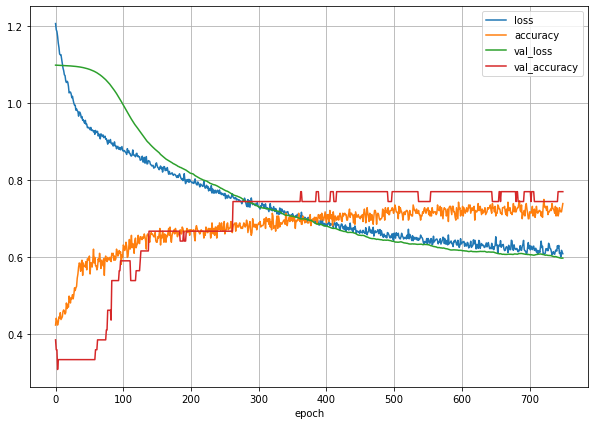

Test loss: 0.5966659188270569
Test accuracy: 0.7692307829856873


In [93]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.xlabel('epoch')
plt.grid()
plt.show()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [94]:
def process_test_buys(tickers, SEQ_LEN, SHIFT):
    Sequential_data = []
    for ticker in tickers:
        df = set_data(ticker)[-SHIFT:]

        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in
        
        for i in df.values:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!
        
        Sequential_data = Sequential_data + sequential_data
        
    X = []; y = []; z = []
    for seq, target, actual in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        z.append(actual)

    return np.array(X).astype("float64"), np.array(y).astype("uint8"), np.array(z).astype("float64")

In [95]:
df = set_data(ticker)

sequential_data = []  # this is a list that will CONTAIN the sequences
prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

for i in df.values:  # iterate over the values
    prev_days.append([n for n in i[:-2]])  # store all but the target
    if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
        sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!

        
buy = []; notbuy = []; maybe = []

for seq, target, actual in sequential_data:  # iterate over the sequential data
    if target == 0:
        maybe.append([seq, target, actual])
    elif target == 1:
        notbuy.append([seq, target, actual]) 
    elif target == 2:
        buy.append([seq, target, actual])  
        

In [96]:
last_trading_days = 100
test_x, test_y, test_z = process_test_buys(tickers_test, SEQ_LEN, last_trading_days)

In [97]:
output = model.predict(test_x)

In [98]:
results = []; total = 0
for i, j in zip(output, test_z):
    if np.argmax(i) == 2:
        total += 1
#         results.append([i,j])
        results.append(j)

In [99]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Average daily return: %f percent, over %d trades.' % (np.average(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period. The last 100 trading days.
Average daily return: 2.329015 percent, over 31 trades.
You started with $5000 and finished with $10091 after 31 trades.


In [100]:
print(results)

[2.347376935288459, 2.112395057860783, 3.188869735746591, -1.5694116217555676, 1.0874764161835415, -2.2103989018587344, -0.5628833462154925, -0.5422291794853207, 4.26302747306484, 7.179760700093607, 4.368515841678211, 5.41504115382172, 5.001216213592574, 4.204014801309497, 0.10475245871657268, 0.8335003685586262, 0.6304627786145156, -1.2897125600689563, 4.043363727909655, 4.305987434505565, 1.04535839203721, -3.2955254715018367, 8.421855178188121, 3.8091279399722566, 5.167216721138401, 0.3401550511611173, 1.9410466601869292, 0.8462584169203646, 2.8748993450455895, 6.239069927025254, 1.8988795854689489]


In [101]:
results = []; total = 0
for i, j in zip(output, test_z):
    if i[2] > 0.6:
        total += 1
#         results.append([i,j])
        results.append(j)

In [102]:
print('Trading period. The last %d trading days.' % (last_trading_days))
print('Average daily return: %f percent, over %d trades.' % (np.average(results), len(results)))
start = 5000
finish = start
for i in results:
    finish = finish + (i/100) * finish
    
print('You started with $%d and finished with $%d after %d trades.' % (start, finish, len(results)))

Trading period. The last 100 trading days.
Average daily return: 4.236571 percent, over 16 trades.
You started with $5000 and finished with $9685 after 16 trades.


In [103]:
print(results)

[3.188869735746591, 4.26302747306484, 7.179760700093607, 4.368515841678211, 5.41504115382172, 5.001216213592574, 4.204014801309497, 0.6304627786145156, 4.043363727909655, 4.305987434505565, 8.421855178188121, 3.8091279399722566, 1.9410466601869292, 2.8748993450455895, 6.239069927025254, 1.8988795854689489]


model.summary()

In [88]:
model.get_weights()

[array([[ 0.00312643, -0.18769857,  0.0380633 ,  0.0722277 ,  0.05058531,
          0.03609235, -0.09786587, -0.18948594,  0.08622011, -0.08056463,
          0.18902671,  0.16548006, -0.18880107, -0.01695134,  0.08615918,
         -0.00163658, -0.13285983,  0.19308513,  0.05517261, -0.00224075,
         -0.1022841 ,  0.18436533,  0.2188085 ,  0.1760114 , -0.0074158 ,
          0.03185357,  0.21743545,  0.22136943, -0.19212668, -0.03917618,
          0.13469195, -0.09434514,  0.05589853, -0.05378037, -0.19692928,
          0.02270586, -0.0365977 ,  0.12564209,  0.08942094,  0.18988153,
          0.0690225 ,  0.01604605,  0.1429162 ,  0.19095956,  0.11380467,
         -0.2027902 ,  0.1375719 , -0.0689759 ,  0.12338183, -0.05350982,
          0.06561334,  0.17109035, -0.16426174,  0.12083419,  0.10378926,
         -0.18805209,  0.07786953, -0.16585672,  0.05414619, -0.11606155,
         -0.08931287,  0.0936529 , -0.09009225, -0.09815032, -0.16557518,
          0.1472611 ,  0.19725555,  0.

In [108]:

if os.path.isfile('FAS_modle.h5') is False:
    model.save('FAS_modle.h5')


In [109]:
model1 = load_model('FAS_modle.h5')

In [110]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 2, 32)             4608      
_________________________________________________________________
batch_normalization_8 (Batch (None, 2, 32)             128       
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                24832     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
Total params: 34,179
Trainable params: 33,987
Non-trainable params: 192
________________________________________________